<a href="https://colab.research.google.com/github/PengJuan-AI/TensorFlow_projects/blob/main/09_SkimLit_nlp_milestone_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Milestone Project 2: SkimLit 📝
** The purpose of this notebook is to build an NLP model to make reading medical abstracts easier.**

### Original Paper
The paper we're replicating is [a Dataset for Sequential Sentence Classification in Medical Abstracts](https://arxiv.org/abs/1710.06071).

The model architecture that they use to achieve the best results is here: https://arxiv.org/pdf/1612.05251.pdf

When it was released, the paper presented a new dataset called PubMed 200k RCT which consists of ~200,000 labelled Randomized Controlled Trial (RCT) abstracts.

The goal of the dataset was to explore the ability for NLP models to classify sentences which appear in sequential order.

In other words, given the abstract of a RCT, what role does each sentence serve in the abstract?

## What is the task
What the Skimlit model doing is to transfer a hard-to-read abstract into a easier-to-read one. (many-to-one problem)
* Input -  a sentence in one abstract
* Output - a label

What is going to include in this project:
* Downloading a text dataset.
* Writing a preprocessing function for our text data.
* Setting up multiple modelling experiments _with different levels of embeddings_.
* Building _multimodal model_ to take in different sources of data.
* Finding the most wrong prediction examples.

## Additional

Some motivation!

> Machine Learning Engineer
> 1. Download a paper.
> 2. Implement it.
> 3. Keep doing this until you have skills.
> 4. Machine learning engineering also involves building infrastructure around your model/data preprocessings steps.

## Get helper function

In [1]:
# get helper functions we write before
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-09-30 18:31:18--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-09-30 18:31:18 (68.5 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [2]:
# Import calculate_results helper function
from helper_functions import calculate_results

## Get data

Since we'll be replicating the paper, let's download the dataset they used (PubMed 200k RCT)

Find the data of a paper on Github: https://github.com/Franck-Dernoncourt/pubmed-rct

In [3]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Receiving objects: 100% (33/33), 177.08 MiB | 26.57 MiB/s, done.
Resolving deltas: 100% (12/12), done.
Updating files: 100% (13/13), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


PubMed 20k is a subset of PubMed 200k, we experiment on 20k dataset and then scale up to the whole dataset.

The first step should be scan through the dataset (or subsets) to check the format of the dataset. Further we need to write a function to preprocess the dataset so that make it ready for our model.

In [4]:
# Check what files are in the PubMed_20k dataset
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/ # this dataset replace number with @

dev.txt  test.txt  train.txt


In [5]:
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [6]:
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt']

## Preprocess data

**Become One with Data**

> Visualize, visualize, visualize

Read file with Python: https://realpython.com/read-write-files-python/

In [7]:
# Read all lines of target files
def get_lines(filename):
  """
  Reads filename and returns the lines pf text as a list

  Args:
    filename: a string containing the target filepath.

  Return:
    A list of strings with one string per line from the target file.
  """
  with open(filename, 'r') as f:
    return f.readlines()

In [8]:
# Let's read in the training lines
train_lines = get_lines(data_dir+"train.txt") # read the lines in the training file
train_lines[:35]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

How do we want our data to look?

```python
# A list of dictory data structure
[{'line_number': 0,
  'target': RESULTS, # or METHODS or OBJECTIVE or BACKGROUND or CONCLUSION
  'text': ...,
  'total_lines': ...,
}]
```

In [9]:
def preprocess_text_with_line_numbers(filename):
  """Returns a list of dictionaries of abstract line data.

  Takes in filename, reads its contents and sorts through each line,
  extracting things like the target label, the text of the sentence,
  how many sentences are in the current abstract and what sentence number
  the target line is.

  Args:
      filename: a string of the target text file to read and extract line data
      from.

  Returns:
      A list of dictionaries each containing a line from an abstract,
      the lines label, the lines position in the abstract and the total number
      of lines in the abstract where the line is from. For example:

      [{"target": 'CONCLUSION',
        "text": The study couldn't have gone better, turns out people are kinder than you think",
        "line_number": 8,
        "total_lines": 8}]
  """
  input_lines = get_lines(filename) # get all lines from filename
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts

  # Loop through each line in target file
  for line in input_lines:
    if line.startswith("###"): # check to see if line is an ID line
      abstract_id = line
      abstract_lines = "" # reset abstract string
    elif line.isspace(): # check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

      # Iterate through each line in abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create empty dict to store data from line
        target_text_split = abstract_line.split("\t") # split target label from text
        line_data["target"] = target_text_split[0] # get target label
        line_data["text"] = target_text_split[1].lower() # get target text and lower it
        line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract?
        line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are in the abstract? (start from 0)
        abstract_samples.append(line_data) # add line data to abstract samples list

    else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
      abstract_lines += line

  return abstract_samples

In [10]:
def preprocess_text_data(filename):
  """
  Returns a list of dictionaries of abstract line data.

  Take in filename, reads its contents through each line,
  extracting attributes - line_number, target, text and total_line.
  """
  inputlines = get_lines(filename)
  abstract = []
  processed_data = []
  for line in inputlines:
    if line.startswith("###"): # is the first line of an abstract (skip)
      if len(abstract) == 0:
        continue
      else: # comes to another '###' means that it comes to a new abstract, so we need to preprocess the last abstract
        total_line = len(abstract)
        for n,sentence in enumerate(abstract):
          sentence = sentence.strip("\n").split('\t')
          # print(f"Line number is {n}\n {sentence}")
          abstract_dict = {"line_number": n,
                         "target": sentence[0],
                         "text": sentence[1].lower(),
                         "total_line": total_line}
          processed_data.append(abstract_dict)
        # reset the abstract contents
        abstract = []
    # elif line=='\n': # skip
    elif line.isspace():
      continue
    else:
      abstract.append(line)

  return processed_data

In [11]:
%%time
train_samples = preprocess_text_data(data_dir+'train.txt')
val_samples = preprocess_text_data(data_dir+'dev.txt') # dev.txt is another name for validation data
test_samples = preprocess_text_data(data_dir+'test.txt')
len(train_samples), len(val_samples), len(test_samples)

CPU times: user 539 ms, sys: 95.4 ms, total: 635 ms
Wall time: 945 ms


(180028, 30198, 30117)

In [12]:
# try functions in course
%%time
train_samples = preprocess_text_with_line_numbers(data_dir+'train.txt')
val_samples = preprocess_text_with_line_numbers(data_dir+'dev.txt')
test_samples = preprocess_text_with_line_numbers(data_dir+'test.txt')
len(train_samples), len(val_samples), len(test_samples)

CPU times: user 730 ms, sys: 76.4 ms, total: 806 ms
Wall time: 1.27 s


(180040, 30212, 30135)

In [13]:
train_samples[:10]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

Turn it into DataFrame to further visualize it.

In [14]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

In [15]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


In [16]:
# Distribution of labels
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

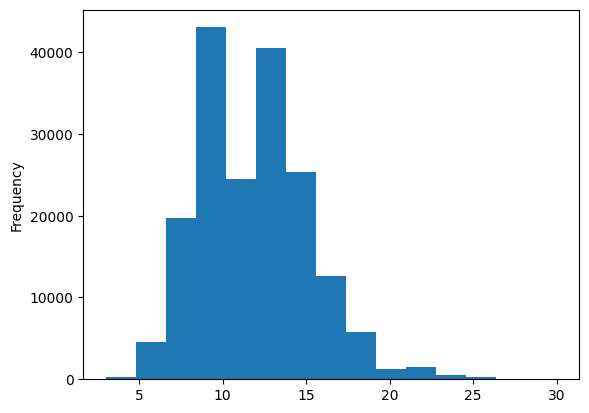

In [17]:
# The length of different lines
train_df.total_lines.plot.hist(bins=15);

Most of the abstracts have total lines between `(5, 18)`.

### Get list of sentences

In [18]:
# Convert abstract text lines into lists
# train_sentences = train_df["text"].to_numpy()
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

## Make numeric labels (ML models require numeric labels)

### One-hot encoding

In [19]:
# One hot encoder
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
one_hot_encoder = OneHotEncoder(sparse_output=False) # tf doesn't support tensorflow sparse matrix format so we set it False
# ordinal_encoder = OrdinalEncoder(dtype='int32')

one_hot_encoder.fit(train_df[["target"]])
train_labels_onehot = one_hot_encoder.transform(train_df[["target"]])
train_labels_onehot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [20]:
val_labels_onehot = one_hot_encoder.transform(val_df[["target"]])
test_labels_onehot = one_hot_encoder.transform(test_df[["target"]])

### Ordinal encoding

```python
ordinal_encoder.fit(train_df[["target"]])
train_labels = ordinal_encoder.transform(train_df[["target"]])
train_labels[:10]

# array([[3],
#        [2],
#        [2],
#        [2],
#        [2],
#        [2],
#        [4],
#        [4],
#        [4],
#        [4]], dtype=int32)
```

### Label encoding

In [21]:
from sqlalchemy import Label
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df.target)
val_labels_encoded = label_encoder.transform(val_df.target)
test_labels_encoded = label_encoder.transform(test_df.target)

# check the training labels
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [22]:
# Get class names and number of classes from LabelEncoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Creating a Series of Experiments

Now we're going to try out a series of experiments and see which one works.

And the first model is the baseline mode. Here we use TF-IDF Multinomial Naive Bayes Classifier.

1. Naive Bayes with TF-IDF encoder
2. Conv1D with token embeddings
3. TensorFlow Hub Pretrained Feature Extractor
4. Conv1D wuth character embeddings
5. Pretrained token embeddings + character embeddings
6. Pretrained token embeddings + character embeddings + positional embeddings

### Model 0 - baseline (Naive Bayes)

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0 = Pipeline([
    ('tf-idf', TfidfVectorizer()),
    ('clf', MultinomialNB())
    ])

model_0.fit(train_sentences, train_labels_encoded)
model_0.score(val_sentences, val_labels_encoded)

0.7218323844829869

In [24]:
# Make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [25]:
# compare the preds and true labels using our helper function -> calculate_results()
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
baseline_results = calculate_results(val_labels_encoded, baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

⚠️ **Remider**:

If the `train_sentences` is `numpy` type, then error:
```
AttributeError: 'numpy.ndarray' object has no attribute 'lower'
```
After change to `list` type, it works.


## Preparing text to numeric format for deep sequence model

Create vectorization and embedding layers.



In [26]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [27]:
# How long is each sentence on average
# Need to define the output length in textorization
sentence_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sentence_len = np.mean(sentence_lens)
avg_sentence_len

26.338269273494777

So the average length of sentence in the training data set is 26

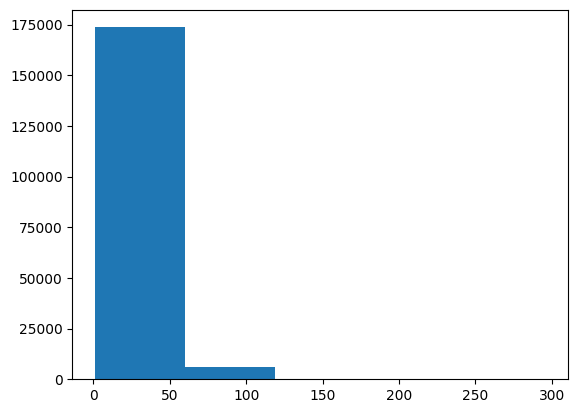

In [28]:
# The distribution
import matplotlib.pyplot as plt
plt.hist(sentence_lens, bins=5);

In [29]:
# How long of a sentence length cover 95% of examples?
out_seq_len = int(np.percentile(sentence_lens, 95))
out_seq_len

55

In [30]:
# The maximum sequence length
max(sentence_lens)

296

> 💡 The steps here help us define the `output_sequence_length` so that it can cover the majority of our training samples.

### Create text vectorizer layer

We want to make a layer which maps our texts from words to numbers.

> "I love TensorFlow" -> [0, 1, 2]
> ```
> I = 1
> love = 2
> TensorFlow = 3
> ```

In [31]:
# How many words in our dataset (taken from the paper)
max_vocab = 68000

# Create text vectorizer
from tensorflow.keras.layers import TextVectorization

text_vectorizer = TextVectorization(max_tokens=max_vocab,
                                    output_sequence_length=out_seq_len)


In [32]:
# Adapt to text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [33]:
# Test out text vectorizer on random sentences
import random
random_sentence = random.choice(train_sentences)
print(f"Text:\n {random_sentence}")
print(f"Length of text: {len(random_sentence.split())}\n")
print(f"Vectorized text:\n {text_vectorizer([random_sentence])}")

Text:
 clusters were ambulance service vehicles , which were randomly assigned ( @:@ ) to lucas-@ or manual cpr .
Length of text: 19

Vectorized text:
 [[ 2515     9  6845  1138 16367   126     9    92   123     6 14789    16
   1266  2101     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


In [34]:
# How many words in our training vocabulary
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocab: {len(rct_20k_text_vocab)}")
print(f"Most common words: {rct_20k_text_vocab[:5]}")
print(f"Most common words: {rct_20k_text_vocab[-5:]}")

Number of words in vocab: 64841
Most common words: ['', '[UNK]', 'the', 'and', 'of']
Most common words: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [35]:
# get all the parameters of our text vectorizer
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

### Create custom text embedding

In [36]:
from tensorflow.keras.layers import Embedding

token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab), # all vocab in training dataset
                               output_dim=128, # the larger output dim, the longer training time
                               mask_zero=True, # the benefit is saving space
                               name="token_embedding")

`mask_zero=True` means that if there are lost of zeroes in inputs, the embedding layer will mask it so that improve computing efficiency.

In [37]:
# Show example embedding
print(f"Sentence before vectorization: \n {random_sentence}")
vectorized_sentence = text_vectorizer([random_sentence])
print(f"After vectorization before embedding:\n {vectorized_sentence}")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n {embedded_sentence}")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization: 
 clusters were ambulance service vehicles , which were randomly assigned ( @:@ ) to lucas-@ or manual cpr .
After vectorization before embedding:
 [[ 2515     9  6845  1138 16367   126     9    92   123     6 14789    16
   1266  2101     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]
Sentence after embedding:
 [[[ 0.00841258 -0.0098284  -0.00831481 ...  0.02466823 -0.02258983
   -0.03687425]
  [-0.01189328 -0.02875928 -0.01082859 ... -0.01904598 -0.02672063
   -0.0306977 ]
  [ 0.01219139 -0.04842472  0.01694759 ...  0.01701876  0.03751098
    0.01208394]
  ...
  [-0.01900665  0.04437226  0.02749523 ... -0.03795921  0.02017993
    0.01706923]
  [-0.01900665  0.04437226  0.02749523 ... -0.03795921  0.02017993
    0.01706923]
  [-0.01900665  0.04437226  0.0

Each words in vectorized sentence (55 in total) is represented by a 128-dim vector.

## Creating datasets (making sure our data loads as fast as possible)

We're going to setup our data to run as fast as possible with the TensorFlow tf.data API, see resources:
* https://www.tensorflow.org/guide/data_performance
* https://www.tensorflow.org/guide/data

In [38]:
# Turn our data into TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_onehot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_onehot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_onehot))

In [39]:
# Turn into prefetch datasets
# Here we want the model to learn the order of inputs so we don't need to shuffle the datasets
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

## Model 1 - Conv1D

In [40]:
from tensorflow.keras import layers
# model_1 = tf.keras.Sequential([
#     text_vectorizer(),
#     token_embed(),
#     layers.Conv1D(),
#     layers.AveragePooling1D(),
#     layers.Dense(5)
# ])
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = token_embed(x)
x = layers.Conv1D(64, kernel_size=5, padding='same', activation='relu')(x)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(num_classes, activation='softmax')(x) # we are working on multiclasses classification - softmax
model_1 = tf.keras.Model(inputs, outputs)

model_1.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [41]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 55)                0         
 ctorization)                                                    
                                                                 
 token_embedding (Embedding  (None, 55, 128)           8299648   
 )                                                               
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_max_pooling1d (Glob  (None, 64)                0         
 alMaxPooling1D)                                                 
                                                             

In [42]:
# Here we have 5627 batches (still large)
len(train_dataset), len(train_sentences)/32

(5627, 5626.25)

In [43]:
model_1_history = model_1.fit(train_dataset, epochs=5,
                              steps_per_epoch=len(train_dataset),
                              # steps_per_epoch=int(0.1*len(train_dataset)), # we train on 10% of training data to get results quicker so we can check what is going well faster.
                              validation_data=valid_dataset,
                              validation_steps=int(0.1*len(valid_dataset)))

Epoch 1/5
5627/5627 [==============================] - 92s 14ms/step - loss: 0.5482 - accuracy: 0.7975 - val_loss: 0.4913 - val_accuracy: 0.8178
Epoch 2/5
5627/5627 [==============================] - 36s 6ms/step - loss: 0.3583 - accuracy: 0.8739 - val_loss: 0.5146 - val_accuracy: 0.8168
Epoch 3/5
5627/5627 [==============================] - 35s 6ms/step - loss: 0.2134 - accuracy: 0.9308 - val_loss: 0.6009 - val_accuracy: 0.8112
Epoch 4/5
5627/5627 [==============================] - 35s 6ms/step - loss: 0.1109 - accuracy: 0.9680 - val_loss: 0.7528 - val_accuracy: 0.7999
Epoch 5/5
5627/5627 [==============================] - 34s 6ms/step - loss: 0.0574 - accuracy: 0.9850 - val_loss: 0.8901 - val_accuracy: 0.7945


Training process for 5 epoch:
```
Epoch 1/5
5627/5627 [==============================] - 395s 70ms/step - loss: 0.5508 - accuracy: 0.7968 - val_loss: 0.4875 - val_accuracy: 0.8228
Epoch 2/5
5627/5627 [==============================] - 393s 70ms/step - loss: 0.3598 - accuracy: 0.8721 - val_loss: 0.5138 - val_accuracy: 0.8225
Epoch 3/5
5627/5627 [==============================] - 393s 70ms/step - loss: 0.2151 - accuracy: 0.9302 - val_loss: 0.6043 - val_accuracy: 0.8085
Epoch 4/5
5627/5627 [==============================] - 381s 68ms/step - loss: 0.1112 - accuracy: 0.9675 - val_loss: 0.7394 - val_accuracy: 0.8015
Epoch 5/5
5627/5627 [==============================] - 410s 73ms/step - loss: 0.0581 - accuracy: 0.9844 - val_loss: 0.8734 - val_accuracy: 0.7962
```

In [44]:
model_1.evaluate(valid_dataset)

945/945 [==============================] - 4s 4ms/step - loss: 0.8853 - accuracy: 0.7944


[0.8853269815444946, 0.7943532466888428]

In [45]:
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs, model_1_pred_probs.shape

945/945 [==============================] - 2s 2ms/step


(array([[1.1213153e-01, 3.3274076e-03, 1.2783905e-03, 8.6511302e-01,
         1.8149637e-02],
        [9.8230225e-01, 2.3653770e-04, 3.2248724e-07, 1.7460069e-02,
         8.4994542e-07],
        [3.5051256e-02, 3.4321417e-09, 4.3858489e-10, 9.6494871e-01,
         1.0104774e-10],
        ...,
        [1.4057602e-07, 6.6273088e-08, 6.6348596e-04, 1.2100619e-08,
         9.9933630e-01],
        [1.0419482e-04, 9.4545412e-01, 1.1315696e-03, 3.7076194e-02,
         1.6233992e-02],
        [2.0928520e-07, 9.9999833e-01, 1.3563409e-06, 3.9214582e-10,
         9.3691732e-08]], dtype=float32),
 (30212, 5))

In [46]:
# convert pred_probs to classes
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([3, 0, 3, ..., 4, 1, 1])>

In [47]:
# Calculate model_1 results
model_1_results = calculate_results(val_labels_encoded, model_1_preds)
model_1_results

{'accuracy': 79.43532371243215,
 'precision': 0.7921076167058605,
 'recall': 0.7943532371243215,
 'f1': 0.7922703656809126}

In [48]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

🎉 Great! We beat the baseline using only one convolutional layer.

## Model 2 - Feature extraction with pretrained token embeddings

In the original paper, the authors used [GloVe embeddings](https://nlp.stanford.edu/projects/glove/), we could use it for our `model_2`. (extension)

However, we are going to use more recent version of pretrained word embedding -- [universal sentence encoder(USE)](https://tfhub.dev/google/universal-sentence-encoder/4).

Or, you can check more pretrained models on [Huggingface](https://huggingface.co/models).

When you're using transfer learning, we would want to find the latest version of some pretrained feature extractors/embeddings.

----
We'll keep the pretrained embeddings frozen (by setting `trainable=False`) and add a trainable couple of layers on the top to tailor the model outputs to our own data.

In [49]:
# Download pretrained Tensorflow Hub USE
import tensorflow_hub as hub
embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                 trainable=False,
                                 name="universal_sentence_encoder") # output is 512 dimensional vector

In [50]:
# Test out the pretrained embedding on a random sentence
# We don't need to vectorize sentences using USE embedding
random_train_sentence = random.choice(train_sentences)
print(f"Random sentence:\n {random_train_sentence}")
use_embedded_sentence = embedding_layer([random_train_sentence])
print(f"Sentence after embeded:\n {use_embedded_sentence[0][:30]}") # first 30
print(f"Length of sentence embedding: {len(use_embedded_sentence[0])}")


Random sentence:
 however , varenicline effects on drinking mediated by cue-elicited brain activation and craving might be best observed among treatment-seekers motivated to reduce their alcohol consumption .
Sentence after embeded:
 [ 0.07008354 -0.02470399 -0.04128301 -0.03029582 -0.04149746  0.0552527
  0.01951495 -0.02183859 -0.03878195  0.06098736  0.00092172  0.00054274
 -0.01019857  0.03362816 -0.09005588 -0.07232979 -0.07902673 -0.03082453
 -0.05968847  0.03000263  0.05002366  0.03874953 -0.02653192 -0.01919223
  0.05113425  0.03606301 -0.04242288 -0.03815406 -0.03846024  0.02190468]
Length of sentence embedding: 512


In [51]:
# Create model 2
# wrong way: inputs = layers.Input(shape=(1,), dtype=tf.string)
inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = embedding_layer(inputs)
x = layers.Dense(128, activation='relu')(pretrained_embedding)
outputs = layers.Dense(num_classes, activation='softmax')(x)

model_2 = tf.keras.Model(inputs, outputs)

model_2.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

❓Question: Why not use convolution layer?

In [52]:
model_2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder  (None, 512)               256797824 
  (KerasLayer)                                                   
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256864133 (979.86 MB)
Trainable params: 66309 (259.02 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [53]:
model_2_history = model_2.fit(train_dataset,
                              epochs=3,
                              steps_per_epoch=int(0.1*len(train_dataset)),
                              validation_data=valid_dataset,
                              validation_steps=int(0.1*len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 11s 14ms/step - loss: 0.9169 - accuracy: 0.6506 - val_loss: 0.7950 - val_accuracy: 0.6885
Epoch 2/3
562/562 [==============================] - 8s 15ms/step - loss: 0.7682 - accuracy: 0.7020 - val_loss: 0.7540 - val_accuracy: 0.7041
Epoch 3/3
562/562 [==============================] - 8s 15ms/step - loss: 0.7519 - accuracy: 0.7130 - val_loss: 0.7363 - val_accuracy: 0.7141


`model_2` is training faster than `model_1`. That's because `model_2` doesn't have to train the embedding layer since we set `trainable=False`, while in `model_1`, we have to train our own embedding layer.

In [54]:
model_2.evaluate(valid_dataset)

945/945 [==============================] - 11s 11ms/step - loss: 0.7395 - accuracy: 0.7143


[0.7395492196083069, 0.7142857313156128]

In [55]:
model_2_preds = tf.argmax(model_2.predict(valid_dataset), axis=1)
model_2_preds[:10]

945/945 [==============================] - 10s 11ms/step


<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 1, 3, 2, 4, 2, 2, 2, 4, 1])>

In [56]:
# Calculate results from TF hub pretrained embedding
model_2_results = calculate_results(val_labels_encoded, model_2_preds)
model_2_results

{'accuracy': 71.42857142857143,
 'precision': 0.7146234274574756,
 'recall': 0.7142857142857143,
 'f1': 0.7116830662108038}

In [57]:
 baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

Well, it seems like `model_2` does not outperform the baseline. It's okay, we will keep doing experiments.

## Model 3 - Conv1D with Character embeddings.

The paper which we're replicating states they used a combination of token and character-level embeddings.

In previous experiment, we used token-level embeddings. Next, we'll do the similar steps for characters if we want to use char-level embeddings.

### Character-level embedding

Each character gets turned into a feature vector.

To create a character-level vectorizer, we need to format our data in this way:  
"I love Tensorflow" -> ['I', 'l','o','v','e','T','e','n','s','o','r','f','l','o','w']

## Creating a character-level tokenizer

In [58]:
train_sentences[:5]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .']

In [59]:
# Make function to split sentences into character
def split_char(text):
  return " ".join(list(text))

# Text splitting non-character-level sequence into characters
split_char(random_train_sentence)

'h o w e v e r   ,   v a r e n i c l i n e   e f f e c t s   o n   d r i n k i n g   m e d i a t e d   b y   c u e - e l i c i t e d   b r a i n   a c t i v a t i o n   a n d   c r a v i n g   m i g h t   b e   b e s t   o b s e r v e d   a m o n g   t r e a t m e n t - s e e k e r s   m o t i v a t e d   t o   r e d u c e   t h e i r   a l c o h o l   c o n s u m p t i o n   .'

In [60]:
" ".join(list(train_sentences[0]))

't o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .'

In [61]:
from tensorflow.python.ops.gen_array_ops import split
# Split sequence-level data into char-level data
train_chars = [split_char(s) for s in train_sentences]
val_chars = [split_char(s) for s in val_sentences]
test_chars = [split_char(s) for s in test_sentences]
train_chars[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [62]:
# What's the average length?
# char_lens = [len(chars.split(" ")) for chars in train_chars]
char_lens = [len(s) for s in train_sentences] # len(sentences) calculates all chars in one sentence
char_avg_len = np.mean(char_lens)
char_avg_len

149.3662574983337

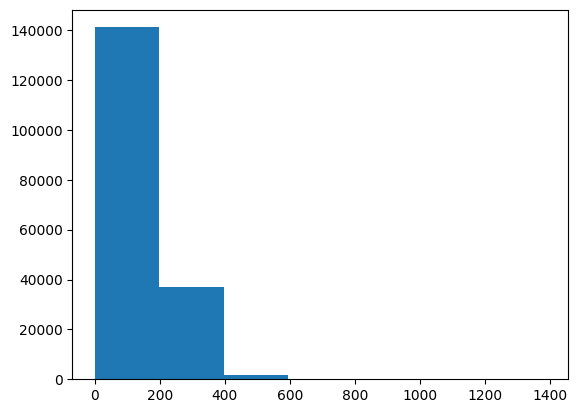

In [63]:
# check the distribution
import matplotlib.pyplot as plt
plt.hist(char_lens, bins=7);

In [64]:
# Find what character length covers 95% if sequences
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [65]:
# Get all keyboard characters
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In char-level instead of token-level, the number of all character is fixed, which is all the characters on our keyboard.

In [66]:
# Create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2 # 2 for space and OOV token (OOV = out of vocabulary)
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    output_sequence_length=output_seq_char_len,
                                    # standardize=None, #set standardize to "None" if we want to save punctuations.
                                    name='char_vectorizer')

In [67]:
# Adapt char_vectorizer to training characters
char_vectorizer.adapt(train_chars)

In [68]:
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common character: {char_vocab[:5]}")
print(f"5 most common character: {char_vocab[-5:]}")

Number of different characters in character vocab: 28
5 most common character: ['', '[UNK]', 'e', 't', 'i']
5 most common character: ['k', 'x', 'z', 'q', 'j']


In [69]:
# Test character vectorizer
random_train_chars = random.choice(train_chars)
print(f"Chars-level sentence: {random_train_chars}")
print(f"Length of random train chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"Vectorized random trian chars: {vectorized_chars}")
print(f"Length of vectoried chars: {len(vectorized_chars[0])}")

Chars-level sentence: p a r t i c i p a n t s   w e r e   e n r o l l e d   f r o m   a   s i n g l e   r e f e r r a l   c e n t e r   r e c r u i t i n g   n a t i o n w i d e   i n   n o r w a y   .
Length of random train chars: 78
Vectorized random trian chars: [[14  5  8  3  4 11  4 14  5  6  3  9 20  2  8  2  2  6  8  7 12 12  2 10
  17  8  7 15  5  9  4  6 18 12  2  8  2 17  2  8  8  5 12 11  2  6  3  2
   8  8  2 11  8 16  4  3  4  6 18  6  5  3  4  7  6 20  4 10  2  4  6  6
   7  8 20  5 19  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 

### Creating a character-level embedding

In [70]:
char_embed = layers.Embedding(input_dim=len(char_vocab), # input_dim - size of the vocabulary
                              output_dim=25, # as in the paper. output_dim - dimensions of the output vectors
                              mask_zero=True,
                              name="char_embed"
                              )

In [71]:
# Test char_embed layer
print(f"Char-level sentence: {random_train_chars}")
embeded_chars = char_embed(char_vectorizer([random_train_chars]))
print(f"Embeded char-level vector: {embeded_chars}")
print(f"Character embedding shape: {embeded_chars.shape}")

Char-level sentence: p a r t i c i p a n t s   w e r e   e n r o l l e d   f r o m   a   s i n g l e   r e f e r r a l   c e n t e r   r e c r u i t i n g   n a t i o n w i d e   i n   n o r w a y   .
Embeded char-level vector: [[[-0.01463505  0.02975739  0.04851601 ...  0.04717281 -0.02135906
    0.03754434]
  [ 0.03793479  0.04618533  0.04592827 ...  0.04875134 -0.01156086
   -0.01408987]
  [-0.0025358  -0.00153489  0.03651707 ... -0.00900424 -0.00130539
   -0.01951008]
  ...
  [-0.04231771 -0.01281928  0.04619889 ... -0.02448595 -0.03572124
   -0.01732997]
  [-0.04231771 -0.01281928  0.04619889 ... -0.02448595 -0.03572124
   -0.01732997]
  [-0.04231771 -0.01281928  0.04619889 ... -0.02448595 -0.03572124
   -0.01732997]]]
Character embedding shape: (1, 290, 25)


Interpretion of shape `(1, 290, 25)`:

- 1 - one sentence
- 290 - length of char-level vector (vectorized sentence)
- 25 - dimension of representation for one character

### Prepare dataset

In [72]:
# crate char-level datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_onehot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_onehot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_onehot)).batch(32).prefetch(tf.data.AUTOTUNE)

# check if the dataset is PrefetchDataset format
train_char_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

### Building a Conv1D model with character embeddings

In [73]:
# create model 3 with character-level embedding
inputs = layers.Input(shape=(1,), dtype=tf.string)
vectorized_layer = char_vectorizer(inputs)
embedding = char_embed(vectorized_layer)
x = layers.Conv1D(64, kernel_size=5, padding='same',activation='relu')(embedding)
x = layers.GlobalMaxPool1D()(x) # or avaerga pooling
outputs = layers.Dense(len(class_names), activation='softmax')(x)

model_3 = tf.keras.Model(inputs, outputs)

# Compile
model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [74]:
model_3.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVecto  (None, 290)               0         
 rization)                                                       
                                                                 
 char_embed (Embedding)      (None, 290, 25)           700       
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d_1 (Gl  (None, 64)                0         
 obalMaxPooling1D)                                               
                                                                 
 dense_3 (Dense)             (None, 5)                 325 

In [75]:
# Fit the model for 3 epochs
model_3_history = model_3.fit(train_char_dataset,
                              steps_per_epoch=int(0.1*len(train_char_dataset)),
                              epochs=3,
                              validation_data=val_char_dataset,
                              validation_steps=int(0.1*len(val_char_dataset))
                              )

Epoch 1/3
562/562 [==============================] - 6s 8ms/step - loss: 1.2658 - accuracy: 0.4913 - val_loss: 1.0486 - val_accuracy: 0.5838
Epoch 2/3
562/562 [==============================] - 3s 6ms/step - loss: 1.0014 - accuracy: 0.6030 - val_loss: 0.9364 - val_accuracy: 0.6366
Epoch 3/3
562/562 [==============================] - 3s 5ms/step - loss: 0.9254 - accuracy: 0.6370 - val_loss: 0.8708 - val_accuracy: 0.6702


In [76]:
model_3.evaluate(val_char_dataset)

945/945 [==============================] - 4s 4ms/step - loss: 0.8850 - accuracy: 0.6559


[0.8849708437919617, 0.6558651924133301]

In [77]:
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs

945/945 [==============================] - 3s 3ms/step


array([[0.11531353, 0.40916464, 0.05387086, 0.35729074, 0.06436022],
       [0.27966514, 0.47941038, 0.01530067, 0.17979294, 0.04583086],
       [0.10908632, 0.54019   , 0.09490548, 0.20394006, 0.05187817],
       ...,
       [0.01889737, 0.03932066, 0.13354526, 0.02471387, 0.7835228 ],
       [0.0350147 , 0.16459562, 0.25992697, 0.03797746, 0.5024853 ],
       [0.31324735, 0.5134213 , 0.03425267, 0.10223677, 0.03684184]],
      dtype=float32)

In [78]:
# Convert probabilities to class labels
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 1, ..., 4, 4, 1])>

In [79]:
model_3_results = calculate_results(val_labels_encoded, model_3_preds)
model_3_results

{'accuracy': 65.58652191182311,
 'precision': 0.6528441225463824,
 'recall': 0.6558652191182311,
 'f1': 0.6491017161961629}

In [80]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Model 4 - Combine token embeddings with character embeddings

1. Create a token-level embedding model (similar `model_1`)
2. Create a character-level embedding model (similar to `model_3`)
3. Combine 1&2 with a concatenate (`layer.Concatenate`)
4. Build a series of output layers on top of 3
5. Construct a model which takes token and character-level sequences as input and produces sequnce label probabilities as output


In [81]:
# Download pretrained Tensorflow Hub USE
import tensorflow_hub as hub
tfhub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                 trainable=False,
                                 name="universal_sentence_encoder") # output is 512 dimensional vector

In [82]:
# 1. Set up token inputs/model
token_inputs = layers.Input(shape=[], dtype=tf.string, name='token_input')
token_embeddings = tfhub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation='relu')(token_embeddings) # in original paper, it use 300-dimension
token_model = tf.keras.Model(inputs=token_inputs, outputs=token_outputs)

# 2. Set up char inputs/model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)  # bidirection essentially double the hidden units
char_model = tf.keras.Model(inputs=char_inputs, outputs=char_bi_lstm)

# 3. Concatenate token and char inputs
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output,
                                                                  char_model.output])

# 4. Create output layer - adding in Dropout
combined_dropout = layers.Dropout(0.5)(token_char_concat) # regularization
combined_dense = layers.Dense(128, activation='relu')(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation='softmax')(final_dropout)

# 5. Construct model with char and token inputs
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name="model_4_token_and_char_embeddings")

In [83]:
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 token_input (InputLayer)    [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['char_input[0][0]']          
 rization)                                                                                        
                                                                                                  
 universal_sentence_encoder  (None, 512)                  2567978 

### Plot hybrid token and char model

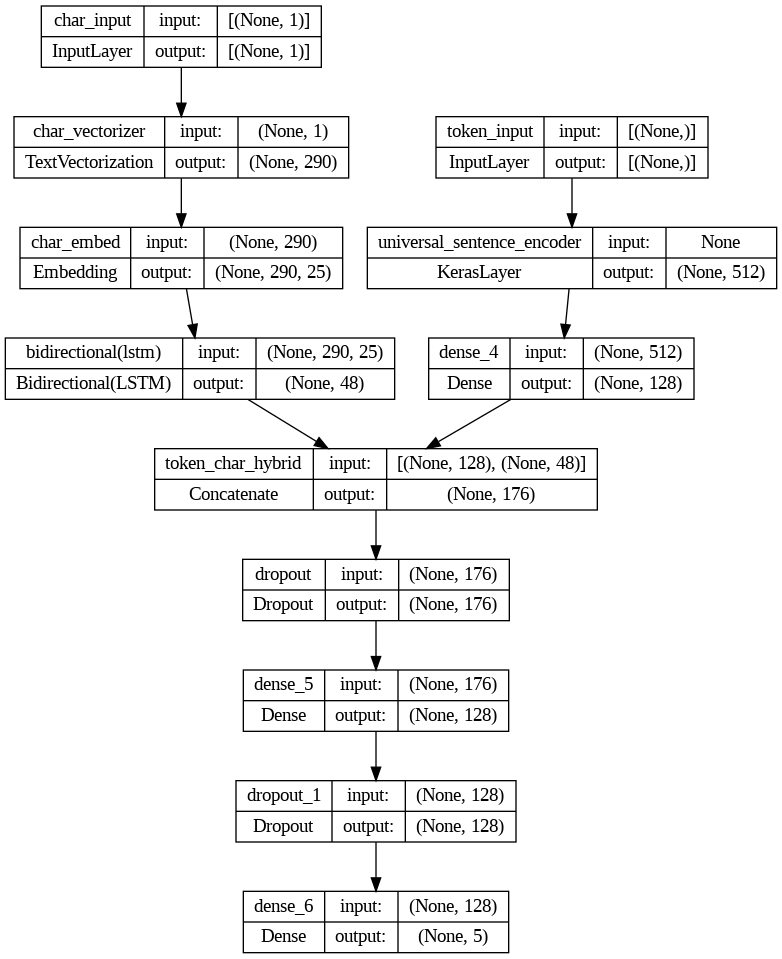

In [84]:
from keras.utils import plot_model
plot_model(model_4, show_shapes=True)

In [85]:
# compile token char hybrid model
model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(), # the original paper used SGD
                metrics=["accuracy"])

### Combining token and character datat into a tf.data.Dataset


In [86]:
# Combine chars and tokens into a dataset - using zip
train_token_char_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars))
train_token_char_labels = tf.data.Dataset.from_tensor_slices(train_labels_onehot) # make the labels
train_token_char_dataset = tf.data.Dataset.zip((train_token_char_data, train_token_char_labels))

# Prefetch and batch train data
train_token_char_dataset = train_token_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
train_token_char_dataset

<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [87]:
# do teh same for val_dataset
val_token_char_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_token_char_labels = tf.data.Dataset.from_tensor_slices(val_labels_onehot) # make the labels
val_token_char_dataset = tf.data.Dataset.zip((val_token_char_data, val_token_char_labels))

# Prefetch and batch train data
val_token_char_dataset = val_token_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_token_char_dataset

<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

> When we prepare our dataset for fitting, remember to align the input order as the architecture of model.


In this case:
```
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name="model_4_token_and_char_embeddings")
```
We should put token_model inputs first then char_model inputs.

### Fitting the model

In [88]:
model_4_history = model_4.fit(train_token_char_dataset,
            steps_per_epoch=int(0.1*len(train_token_char_dataset)),
            epochs=3,
            validation_data=val_token_char_dataset,
            validation_steps=int(0.1*len(val_token_char_dataset)))

Epoch 1/3
562/562 [==============================] - 42s 53ms/step - loss: 0.9831 - accuracy: 0.6067 - val_loss: 0.7658 - val_accuracy: 0.7045
Epoch 2/3
562/562 [==============================] - 26s 46ms/step - loss: 0.7982 - accuracy: 0.6927 - val_loss: 0.7114 - val_accuracy: 0.7330
Epoch 3/3
562/562 [==============================] - 23s 41ms/step - loss: 0.7729 - accuracy: 0.7064 - val_loss: 0.6863 - val_accuracy: 0.7437


In [89]:
model_4.evaluate(val_token_char_dataset)

945/945 [==============================] - 19s 20ms/step - loss: 0.6901 - accuracy: 0.7381


[0.6901470422744751, 0.7380511164665222]

In [90]:
model_4_pred_probs = model_4.predict(val_token_char_dataset)
model_4_pred_probs

945/945 [==============================] - 20s 18ms/step


array([[4.4195354e-01, 3.2157531e-01, 4.4413032e-03, 2.2508585e-01,
        6.9439858e-03],
       [3.6699757e-01, 4.6246845e-01, 4.2950129e-03, 1.6440623e-01,
        1.8328041e-03],
       [3.3104903e-01, 1.4902015e-01, 5.8831234e-02, 4.1999471e-01,
        4.1104838e-02],
       ...,
       [1.2249345e-03, 1.2058535e-02, 7.0541240e-02, 4.0911444e-04,
        9.1576618e-01],
       [1.1409091e-02, 7.5393617e-02, 2.1904618e-01, 4.0652286e-03,
        6.9008589e-01],
       [2.1629073e-01, 4.6079835e-01, 2.4658442e-01, 2.9835636e-02,
        4.6490937e-02]], dtype=float32)

In [91]:
model_4_preds = tf.argmax(model_4_pred_probs,axis=1)
model_4_results = calculate_results(val_labels_encoded, model_4_preds)
model_4_results

{'accuracy': 73.80511055209851,
 'precision': 0.7399819742506097,
 'recall': 0.7380511055209851,
 'f1': 0.7350517931908134}

In [92]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

Results using `SGD()` as optimizer:
```
{'accuracy': 50.324374420759966,
 'precision': 0.3309279442766998,
 'recall': 0.5032437442075997,
 'f1': 0.3989357759486417}
 ```

## Model 5 - Transfer learning with pretrained token embeddings + character embeddings + positional embeddings

Adding positional information - positional embeddings

### Feature engineering

* Take non-obvious features from the data and encoding them numerically to help model learn
* How to add extra sources of data?
* Data augmentation is. aform of feature engineering

In [93]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


> **Note:** Any engineered features used to train a model need to be available at test time.

### Create positional embeddings

In [94]:
# How many different line numbers are there?
train_df["line_number"].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

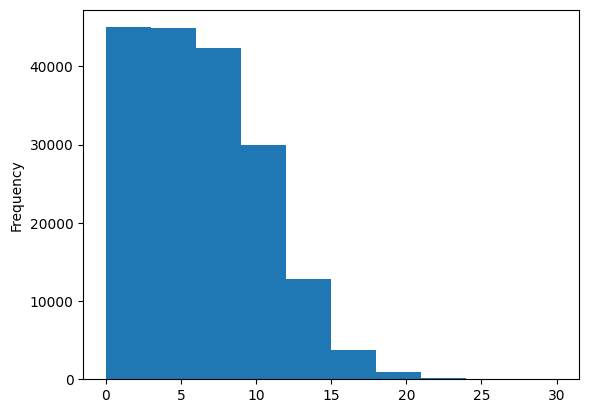

In [95]:
# Check the distribution of line_number column
train_df.line_number.plot.hist();

One step here is that we want to include as many as instances as possible.

If we set the `depth` of one-hot matrix as 30 (the largest number of lines in the train dataset), the vectors of the majority would have many zeros at the end, which means that the computer need to calculate many zeros.

In [96]:
# use tensorfloe to create one-hot-encoded tensors of line_number column
train_line_number_onehot = tf.one_hot(train_df["line_number"].to_numpy(), depth=15)
val_line_number_onehot = tf.one_hot(val_df["line_number"].to_numpy(), depth=15)
test_line_number_onehot = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)
train_line_number_onehot[:10], train_line_number_onehot.shape

(<tf.Tensor: shape=(10, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],
       dtype=float32)>,
 TensorShape([180040, 15]))

Now we've encoded our line numbers feature, let's do the same for `total_lines` feature.

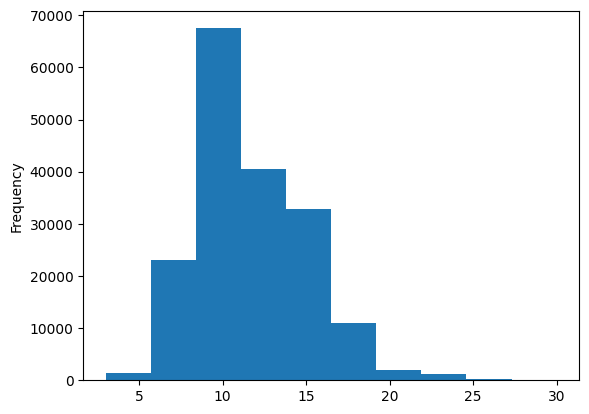

In [97]:
# the distribution of total_line in train dataset
train_df.total_lines.plot.hist();

In [98]:
train_df.total_lines.value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

In [99]:
# check the coverage of. atotal_lines value of 20
np.percentile(train_df.total_lines, 98)

20.0

In [100]:
train_total_lines_onehot = tf.one_hot(train_df["total_lines"], depth=20)
val_total_lines_onehot = tf.one_hot(val_df.total_lines.to_numpy(), depth=20)
test_total_lines_onehot = tf.one_hot(test_df.total_lines.to_numpy(), depth=20)
train_total_lines_onehot[:10], train_total_lines_onehot.shape

(<tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0

### Building a tribuid embedding model

1. Create a token-level model
2. Create a character-level model
3. Create a model for the `line_number` feature
4. Create a model for the `total_lines` feature
5. Combine the outputs of 1 & 2 using `tf.keras.layers.Concatenate`
6. Combine the outputs of 3 & 4 & 5 using `tf.keras.layers.Concatenate`
7. Create an poutput layer to accept the tribrid embedding and output label probabilities.
8. Combine the inputs of 1,2,3,4 and outputs of into a `tf.keras.Model`.

In [101]:
# 1. Token inputs
token_inputs = layers.Input(shape=[], dtype=tf.string, name='token_inputs')
token_embeddings = tfhub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation='relu')(token_embeddings)
token_model = tf.keras.Model(token_inputs, token_outputs)

# 2. char inputs
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name='char_inputs')
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(char_inputs, char_bi_lstm)


In [102]:
train_line_number_onehot[0].shape, train_line_number_onehot[0].dtype

(TensorShape([15]), tf.float32)

In [103]:
# 3. Line number model
line_number_inputs = layers.Input(shape=(15,), dtype=tf.float32, name="line_number_input")
# line_number_embeddings = layers.Embedding()
line_number_outputs = layers.Dense(32, activation='relu')(line_number_inputs)
line_number_model = tf.keras.Model(line_number_inputs, line_number_outputs)

# 4. Total lines model
total_lines_inputs =layers.Input(shape=(20,), dtype=tf.float32, name="total_line_input")
total_lines_outputs = layers.Dense(32, activation='relu')(total_lines_inputs)
total_lines_model = tf.keras.Model(total_lines_inputs, total_lines_outputs)

In [104]:
# 5. Combine token and char embeddings into a hybrid embeddings
combined_embeddings = layers.Concatenate(name="char_token_hybrid_embedding")([token_model.output,
                                                                              char_model.output])
z = layers.Dense(256, activation='relu')(combined_embeddings)
z = layers.Dropout(0.5)(z)

# 6. Combine positional embedding with combined token and char embedding
tribrid_embeddings =layers.Concatenate(name="char_token_positional_embedding")([line_number_model.output,
                                                                                total_lines_model.output,
                                                                                z])

# 7. Create output layer
output_layer = layers.Dense(5, activation='softmax', name="output_layer")(tribrid_embeddings)

# Put together model with all kinds of inputs (a list)
# Remember the order of imputs is important
model_5 =tf.keras.Model(inputs=[line_number_model.input,
                                 total_lines_model.input,
                                 token_model.input,
                                 char_model.input],
                         outputs=output_layer
                         )

In [105]:
model_5.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_inputs (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 token_inputs (InputLayer)   [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['char_inputs[0][0]']         
 rization)                                                                                        
                                                                                                  
 universal_sentence_encoder  (None, 512)                  2567978   ['token_inputs[0][0]']  

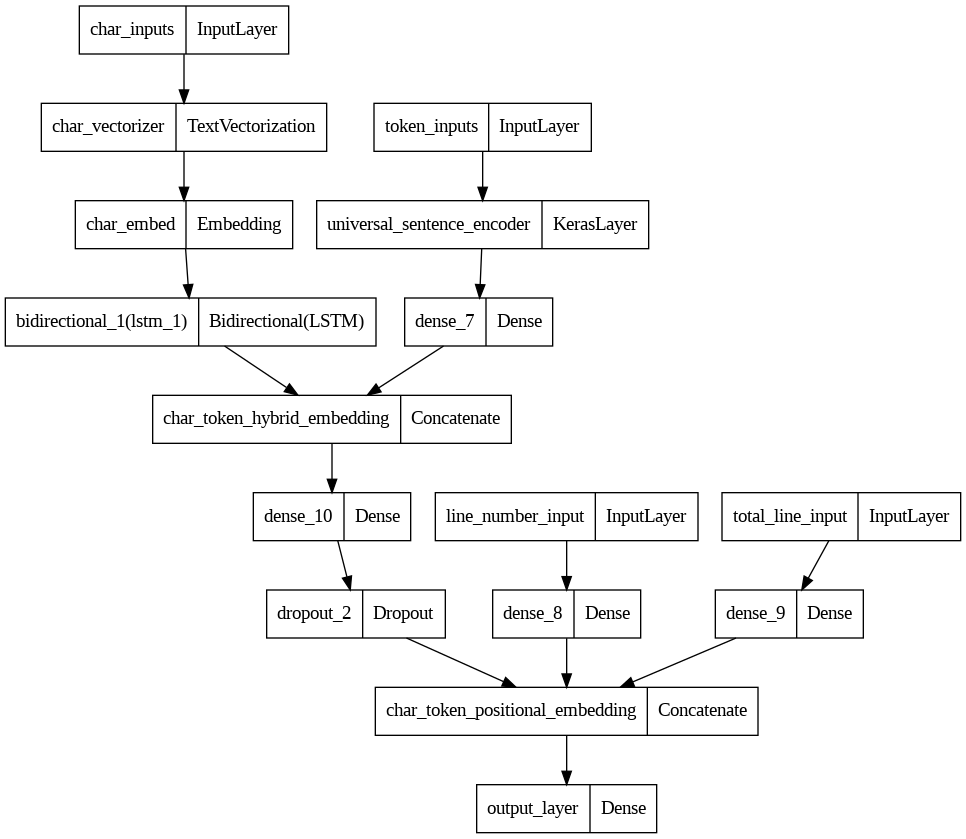

In [106]:
from tensorflow.keras.utils import plot_model
plot_model(model_5)

What is **label_smoothing**?

If our model gets too confident on a single class, it may get stuck.

What label smoothing does is it assigns some of the value from the heighest pred prob to other classes, in turn, hopfully improving generalization: from `[0, 0, 1, 0, 0]` to `[0.01, 0.01, 0.96, 0.01, 0.01]`

More resources: https://pyimagesearch.com/2019/12/30/label-smoothing-with-keras-tensorflow-and-deep-learning/

In [107]:
# COMPILE token , char, and positional embeddings
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), # prevent overfitting
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

### Create tribrid embedding datasets using tf.data


In [139]:
# Create training and validation dataset
train_char_token_pos_data = tf.data.Dataset.from_tensor_slices((train_line_number_onehot,
                                                                train_total_lines_onehot,
                                                                train_sentences,
                                                                train_chars))
train_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(train_labels_onehot)
train_char_token_pos_dataset = tf.data.Dataset.zip((train_char_token_pos_data, train_char_token_pos_labels ))
train_char_token_pos_dataset = train_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# for val
val_char_token_pos_data = tf.data.Dataset.from_tensor_slices((val_line_number_onehot,
                                                                val_total_lines_onehot,
                                                                val_sentences,
                                                                val_chars))
val_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(val_labels_onehot)
val_char_token_pos_dataset = tf.data.Dataset.zip((val_char_token_pos_data, val_char_token_pos_labels ))
val_char_token_pos_dataset = val_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# for test
test_char_token_pos_data = tf.data.Dataset.from_tensor_slices((test_line_number_onehot,
                                                                 test_total_lines_onehot,
                                                                 test_sentences,
                                                                 test_chars))
test_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(test_labels_onehot)
test_char_token_pos_dataset = tf.data.Dataset.zip((test_char_token_pos_data, test_char_token_pos_labels))
test_char_token_pos_dataset = test_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [109]:
# check input shapes
train_char_token_pos_dataset, train_char_token_pos_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

## Fitting, evaluating and making predictions with our tribrid model

In [110]:
model_5.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_inputs (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 token_inputs (InputLayer)   [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['char_inputs[0][0]']         
 rization)                                                                                        
                                                                                                  
 universal_sentence_encoder  (None, 512)                  2567978   ['token_inputs[0][0]']  

In [111]:
model_5_history = model_5.fit(train_char_token_pos_dataset,
                    steps_per_epoch=int(0.1*len(train_char_token_pos_dataset)),
                    epochs=3,
                    validation_data=val_char_token_pos_dataset,
                    validation_steps=int(0.1*len(val_char_token_pos_dataset))
                    )

Epoch 1/3
562/562 [==============================] - 66s 78ms/step - loss: 1.0956 - accuracy: 0.7280 - val_loss: 0.9809 - val_accuracy: 0.8072
Epoch 2/3
562/562 [==============================] - 27s 49ms/step - loss: 0.9659 - accuracy: 0.8164 - val_loss: 0.9488 - val_accuracy: 0.8311
Epoch 3/3
562/562 [==============================] - 26s 47ms/step - loss: 0.9480 - accuracy: 0.8248 - val_loss: 0.9360 - val_accuracy: 0.8305


In [112]:
model_5.evaluate(val_char_token_pos_dataset)

945/945 [==============================] - 24s 26ms/step - loss: 0.9343 - accuracy: 0.8337


[0.9342937469482422, 0.8337084650993347]

In [115]:
model_5_pred_probs = model_5.predict(val_char_token_pos_dataset)

945/945 [==============================] - 20s 21ms/step


In [117]:
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [118]:
model_5_results = calculate_results(val_labels_encoded, model_5_preds)
model_5_results

{'accuracy': 83.37084602144843,
 'precision': 0.8321376455064008,
 'recall': 0.8337084602144843,
 'f1': 0.832374765248366}

In [119]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

Yeah!! We get our best result when adding positional information.

### Training the model on 100% of 20k RCT

### Training the model on 200k RCT

## Compare our model results

In [121]:
from tensorflow.python.autograph.operators.py_builtins import all_
# Combine model results into a dataframe
all_model_results = pd.DataFrame({"model_0_baseline": baseline_results,
                                  "model_1_custom_token_embedding": model_1_results,
                                  "model_2_pretrained_token_embedding": model_2_results,
                                  "model_3_custom_char_embedding": model_3_results,
                                  "model_4_hybrid_char_token_embedding": model_4_results,
                                  "model_5_pos_char_token_embedding": model_5_results})
all_model_results = all_model_results.T
all_model_results

,accuracy,precision,recall,f1
model_0_baseline,72.183238,0.718647,0.721832,0.698925
model_1_custom_token_embedding,79.435324,0.792108,0.794353,0.792270
model_2_pretrained_token_embedding,71.428571,0.714623,0.714286,0.711683
model_3_custom_char_embedding,65.586522,0.652844,0.655865,0.649102
model_4_hybrid_char_token_embedding,73.805111,0.739982,0.738051,0.735052
model_5_pos_char_token_embedding,83.370846,0.832138,0.833708,0.832375


In [122]:
# Reduce the accuracy to same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100

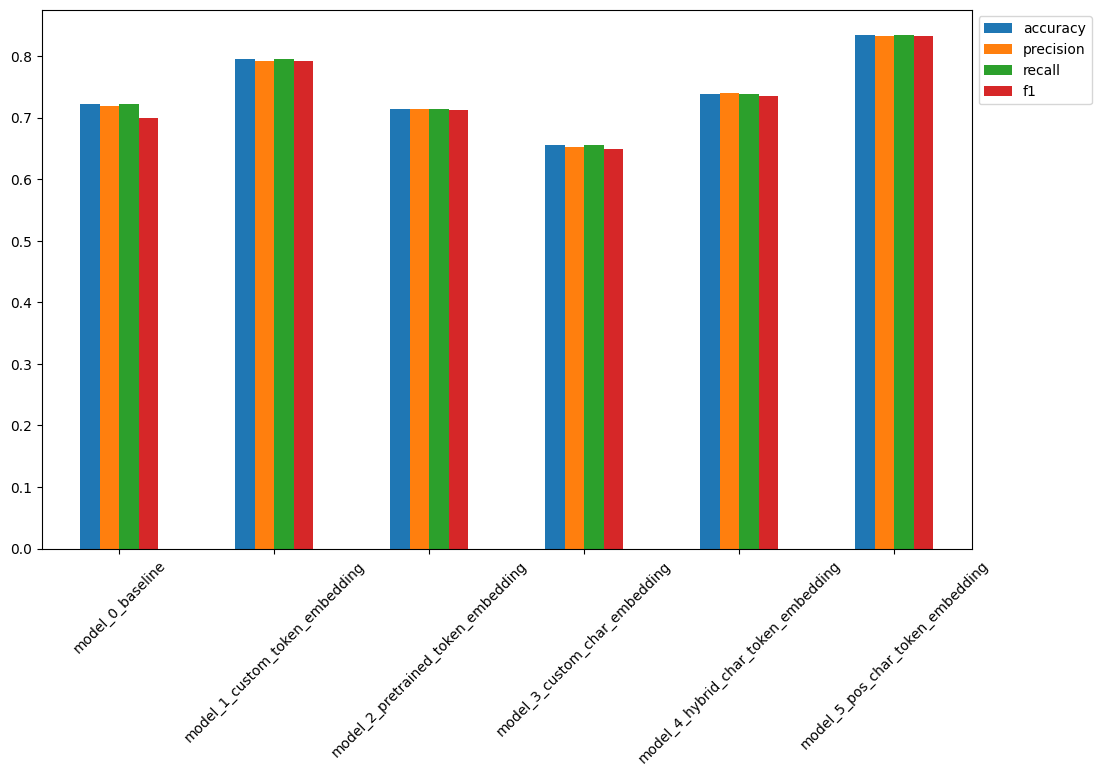

In [124]:
#plot and compare all model results
all_model_results.plot(kind="bar", rot=45, figsize=(12,7)).legend(bbox_to_anchor=(1.0,1.0))

<Axes: >

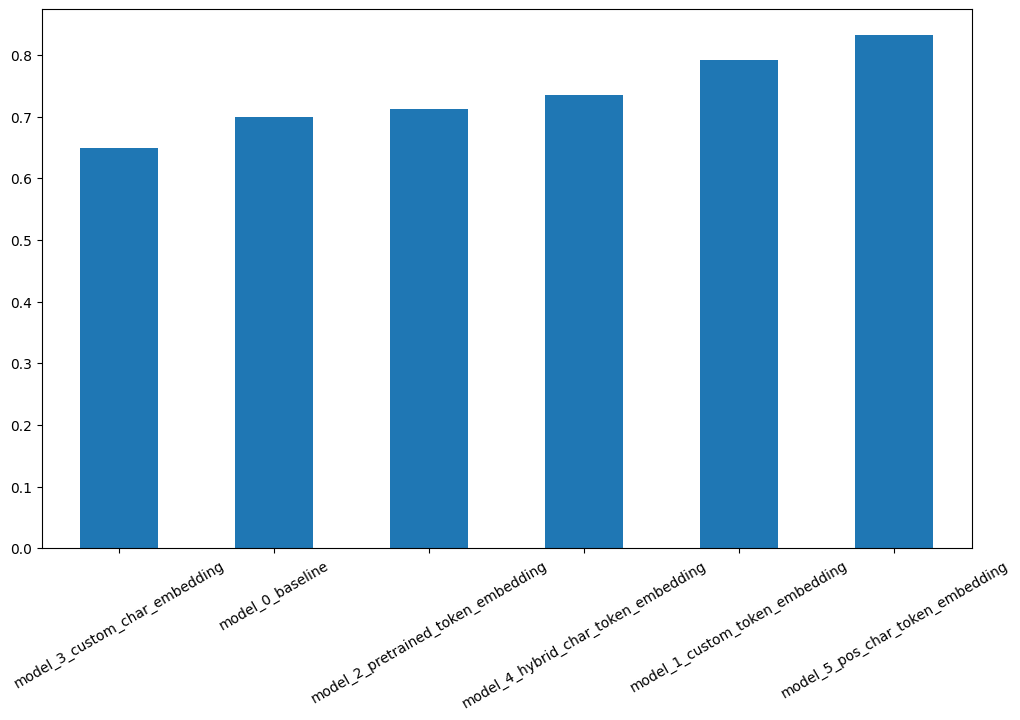

In [128]:
# Sort results by f1-score
all_model_results.sort_values("f1", ascending=True)["f1"].plot(kind="bar", rot=30, figsize=(12,7))

## Save the model to file and load it back - model_5

In [130]:
model_5.evaluate(val_char_token_pos_dataset)

945/945 [==============================] - 20s 21ms/step - loss: 0.9343 - accuracy: 0.8337


[0.9342937469482422, 0.8337084650993347]

In [134]:
model_5.save("skimlit_tribrid_model")

In [135]:
# Load in the best performing model
loaded_model = tf.keras.models.load_model("skimlit_tribrid_model")
loaded_model.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_inputs (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 token_inputs (InputLayer)   [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['char_inputs[0][0]']         
 rization)                                                                                        
                                                                                                  
 universal_sentence_encoder  (None, 512)                  2567978   ['token_inputs[0][0]']  

In [136]:
loaded_model.evaluate(val_char_token_pos_dataset)

945/945 [==============================] - 27s 25ms/step - loss: 0.9343 - accuracy: 0.8337


[0.9342937469482422, 0.8337084650993347]

In [140]:
loaded_model.evaluate(test_char_token_pos_dataset)

942/942 [==============================] - 31s 33ms/step - loss: 0.9425 - accuracy: 0.8289


[0.9424826502799988, 0.8289032578468323]

In [141]:
model_5.evaluate(test_char_token_pos_dataset)

942/942 [==============================] - 21s 22ms/step - loss: 0.9425 - accuracy: 0.8289


[0.9424826502799988, 0.8289032578468323]

## Find the most wrong predictions

### Most wrong for model 1

In [149]:
# Make predictions
pred_classes = [label_encoder.classes_[pred] for pred in model_1_preds]
pred_classes[:10]

['OBJECTIVE',
 'BACKGROUND',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS']

In [155]:
tf.reduce_max(model_1_pred_probs, axis=1)[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([0.865113  , 0.98230225, 0.9649487 , 0.99999475, 0.62407726,
       0.7537601 , 0.9448267 , 0.79074186, 0.9999999 , 0.9995497 ],
      dtype=float32)>

In [159]:
len(pred_classes), val_df.target.shape

(30212, (30212,))

In [160]:
df = pd.DataFrame({"sentence": val_sentences,
                   "label": val_df.target,
                   "pred": pred_classes,
                   "prob": tf.reduce_max(model_1_pred_probs, axis=1)
                   })

df

,sentence,label,pred,prob
0,ige sensitization to aspergillus fumigatus and...,BACKGROUND,OBJECTIVE,0.865113
1,it is not clear whether these patients would b...,BACKGROUND,BACKGROUND,0.982302
2,we sought to determine whether a @-month cours...,OBJECTIVE,OBJECTIVE,0.964949
3,asthmatic patients who were ige sensitized to ...,METHODS,METHODS,0.999995
4,primary outcomes were improvement in quality o...,METHODS,METHODS,0.624077
...,...,...,...,...
30207,pruritus occurred more frequently with the act...,RESULTS,RESULTS,0.999992
30208,three patients in the active-regimen group ( @...,RESULTS,RESULTS,0.998944
30209,hemoglobin values of grade @ ( @ to < @ g per ...,RESULTS,RESULTS,0.999336
30210,rates of response to a @-week interferon-free ...,CONCLUSIONS,CONCLUSIONS,0.945454


In [161]:
df["correct"] = df["label"] == df["pred"]
df.head()

,sentence,label,pred,prob,correct
0,ige sensitization to aspergillus fumigatus and...,BACKGROUND,OBJECTIVE,0.865113,False
1,it is not clear whether these patients would b...,BACKGROUND,BACKGROUND,0.982302,True
2,we sought to determine whether a @-month cours...,OBJECTIVE,OBJECTIVE,0.964949,True
3,asthmatic patients who were ige sensitized to ...,METHODS,METHODS,0.999995,True
4,primary outcomes were improvement in quality o...,METHODS,METHODS,0.624077,True


In [166]:
most_wrongs_top10 = df[df.correct==False].sort_values(by='prob', ascending=False).head(10)
most_wrongs_top10

,sentence,label,pred,prob,correct
7208,"memory , psychomotor and executive functions w...",RESULTS,METHODS,1.0,False
26526,both groups were absolutely comparable for all...,METHODS,RESULTS,1.0,False
2029,vo@ pic increased after at ( @ @ vs @ @ ml o@/...,METHODS,RESULTS,1.0,False
4811,"compared with op , pkep was associated with le...",CONCLUSIONS,RESULTS,1.0,False
17998,patients were followed up until transplant or ...,RESULTS,METHODS,1.0,False
2028,total training impulse ( exercise rehabilitati...,METHODS,RESULTS,1.0,False
23916,these findings emphasize the need for re-exami...,BACKGROUND,CONCLUSIONS,1.0,False
19713,ripc-induced protection was reflected by decre...,METHODS,RESULTS,1.0,False
21580,to evaluate the potential efficacy and safety ...,BACKGROUND,OBJECTIVE,1.0,False
4549,these findings are valid even for deeper pocke...,RESULTS,CONCLUSIONS,1.0,False


## Make example predictions (on RCT abstract from the wild)

Predict using `model_5`.

Go to the website to find: https://pubmed.ncbi.nlm.nih.gov/

* https://pubmed.ncbi.nlm.nih.gov/31986231/
* https://pubmed.ncbi.nlm.nih.gov/25437217/

In [202]:
# get examples (raw)
!wget https://raw.githubusercontent.com/PengJuan-AI/TensorFlow_projects/main/wild_pubmed_data/example1.txt
# !wget https://raw.githubusercontent.com/PengJuan-AI/TensorFlow_projects/main/wild_pubmed_data/example2.txt

--2023-09-30 21:02:37--  https://raw.githubusercontent.com/PengJuan-AI/TensorFlow_projects/main/wild_pubmed_data/example1.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4448 (4.3K) [text/plain]
Saving to: ‘example1.txt’

example1.txt        100%[===================>]   4.34K  --.-KB/s    in 0s      

2023-09-30 21:02:37 (54.1 MB/s) - ‘example1.txt’ saved [4448/4448]



In [196]:
with open("example1.txt", 'r') as f:
  print(f.read())

Background: Infants in the neonatal intensive care unit (NICU) are subjected to stress, including sound of high intensity. The sound environment in the NICU is louder than most home or office environments and contains disturbing noises of short duration and at irregular intervals. There are competing auditory signals that frequently challenge preterm infants, staff and parents. The sound levels in NICUs often exceed the maximum acceptable level of 45 decibels (dB), recommended by the American Academy of Pediatrics. Hearing impairment is diagnosed in 2% to 10% of preterm infants versus 0.1% of the general paediatric population. Noise may cause apnoea, hypoxaemia, alternation in oxygen saturation, and increased oxygen consumption secondary to elevated heart and respiratory rates and may, therefore, decrease the amount of calories available for growth. Elevated levels of speech are needed to overcome the noisy environment in the NICU, thereby increasing the negative impacts on staff, newb

In [203]:
# Process data
def sample_to_df(filename):
  sample = get_lines(filename)
  total_lines = len(sample)
  text = []
  target = []
  line_number = []
  for i, sentence in enumerate(sample):
    sentence = sentence.split(':')
    target.append(sentence[0].upper())
    text.append(sentence[1].strip().lower())
    line_number.append(i)
    # sample_dict["total_line"] = total_lines

  df = pd.DataFrame({"text": text,
                     "target": target,
                     "line_number": line_number,
                     "total_lines": total_lines})
  return df

sample_df = sample_to_df("example2.txt")
sample_df

,text,target,line_number,total_lines
0,"the calories trial is a pragmatic, open, multi...",BACKGROUND,0,5
1,to describe the proposed statistical analyses ...,OBJECTIVE,1,5
2,with the primary and secondary outcomes define...,METHODS,2,5
3,the primary outcome is all-cause mortality at ...,RESULTS,3,5
4,"in keeping with best trial practice, we have d...",CONCLUSIONS,4,5


### Encodings and Embeddings

In [207]:
# Encoding labels
sample_labels_encoded = label_encoder.transform(sample_df.target)
sample_labels_onehot = one_hot_encoder.transform(sample_df[["target"]])
sample_labels_encoded, sample_labels_onehot

(array([0, 3, 2, 4, 1]),
 array([[1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0.]]))

In [208]:
# depth=15 for line_number
line_number_onehot = tf.one_hot(sample_df.line_number, depth=15)
line_number_onehot

<tf.Tensor: shape=(5, 15), dtype=float32, numpy=
array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
      dtype=float32)>

In [209]:
# depth=20 for total_lines
total_lines_onehot = tf.one_hot(sample_df.total_lines, depth=20)
total_lines_onehot

<tf.Tensor: shape=(5, 20), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.]], dtype=float32)>

In [211]:
sample_chars = [split_char(sentence) for sentence in sample_df.text]
sample_chars

['t h e   c a l o r i e s   t r i a l   i s   a   p r a g m a t i c ,   o p e n ,   m u l t i c e n t r e ,   r a n d o m i s e d   c o n t r o l l e d   t r i a l   ( r c t )   o f   t h e   c l i n i c a l   e f f e c t i v e n e s s   a n d   c o s t - e f f e c t i v e n e s s   o f   e a r l y   n u t r i t i o n a l   s u p p o r t   v i a   t h e   p a r e n t e r a l   r o u t e   c o m p a r e d   w i t h   e a r l y   n u t r i t i o n a l   s u p p o r t   v i a   t h e   e n t e r a l   r o u t e   i n   u n p l a n n e d   a d m i s s i o n s   t o   a d u l t   g e n e r a l   c r i t i c a l   c a r e   u n i t s   ( c c u s )   i n   t h e   u n i t e d   k i n g d o m .   t h e   t r i a l   d e r i v e s   f r o m   t h e   n e e d   f o r   a   l a r g e ,   p r a g m a t i c   r c t   t o   d e t e r m i n e   t h e   o p t i m a l   r o u t e   o f   d e l i v e r y   f o r   e a r l y   n u t r i t i o n a l   s u p p o r t   i n   t h e   c r i t i c a l l y   i 

### Predict sample

In [214]:
sample_pred_probs = loaded_model.predict(x=(line_number_onehot,
                                            total_lines_onehot,
                                            tf.constant(sample_df.text), # transfer to tensor
                                            tf.constant(sample_chars)))
sample_pred_probs

1/1 [==============================] - 3s 3s/step


array([[0.3775126 , 0.14397041, 0.06397635, 0.37698764, 0.03755305],
       [0.09703167, 0.04939787, 0.14769836, 0.68840367, 0.0174685 ],
       [0.06972563, 0.03433939, 0.77389693, 0.06032189, 0.06171619],
       [0.03668816, 0.02522487, 0.88259053, 0.03246361, 0.02303289],
       [0.08727522, 0.17135383, 0.62767303, 0.05226656, 0.06143133]],
      dtype=float32)

In [215]:
sample_preds = tf.argmax(sample_pred_probs)
sample_pred_classes = [label_encoder.classes_[pred] for pred in sample_preds]
sample_pred_classes

['BACKGROUND', 'RESULTS', 'OBJECTIVE', 'CONCLUSIONS', 'METHODS']

In [218]:
sample_df.target

0     BACKGROUND
1      OBJECTIVE
2        METHODS
3        RESULTS
4    CONCLUSIONS
Name: target, dtype: object

In [221]:
for i, text in enumerate(sample_df.text):
  print(f"{sample_pred_classes[i]}: {text}")

BACKGROUND: the calories trial is a pragmatic, open, multicentre, randomised controlled trial (rct) of the clinical effectiveness and cost-effectiveness of early nutritional support via the parenteral route compared with early nutritional support via the enteral route in unplanned admissions to adult general critical care units (ccus) in the united kingdom. the trial derives from the need for a large, pragmatic rct to determine the optimal route of delivery for early nutritional support in the critically ill.
RESULTS: to describe the proposed statistical analyses for the evaluation of the clinical effectiveness in the calories trial.
OBJECTIVE: with the primary and secondary outcomes defined precisely and the approach to safety monitoring and data collection summarised, the planned statistical analyses, including prespecified subgroups and secondary analyses, were developed and are described.
CONCLUSIONS: the primary outcome is all-cause mortality at 30 days. the primary analysis will 